### In this notebook I will predict the closing price of a stock using a pytorch LSTM on the variables

Import packages

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import date
import matplotlib
import plotly.express as px

matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('axes',  labelsize=20)
matplotlib.rc('font', **{'size'   : 18, 'family':'monospace'})
matplotlib.rcParams['figure.figsize'] = (12, 5)
matplotlib.rcParams['figure.titlesize'] = 22

# Load Data

In [190]:
raw_df = pd.read_csv('./Data/stockprices.txt')
raw_df = raw_df.drop(['Adj Close'], axis=1)
raw_df

,Date,Open,High,Low,Close,Volume
0,2019-08-09,1197.989990,1203.880005,1183.603027,1188.010010,1065700
1,2019-08-12,1179.209961,1184.959961,1167.671997,1174.709961,1003000
2,2019-08-13,1171.459961,1204.780029,1171.459961,1197.270020,1294400
3,2019-08-14,1176.310059,1182.300049,1160.540039,1164.290039,1578700
4,2019-08-15,1163.500000,1175.839966,1162.109985,1167.260010,1218700
...,...,...,...,...,...,...
247,2020-08-03,1486.640015,1490.469971,1465.640015,1474.449951,2330200
248,2020-08-04,1476.569946,1485.560059,1458.650024,1464.969971,1903500
249,2020-08-05,1469.300049,1482.410034,1463.459961,1473.609985,1979500
250,2020-08-06,1471.750000,1502.390015,1466.000000,1500.099976,1995400


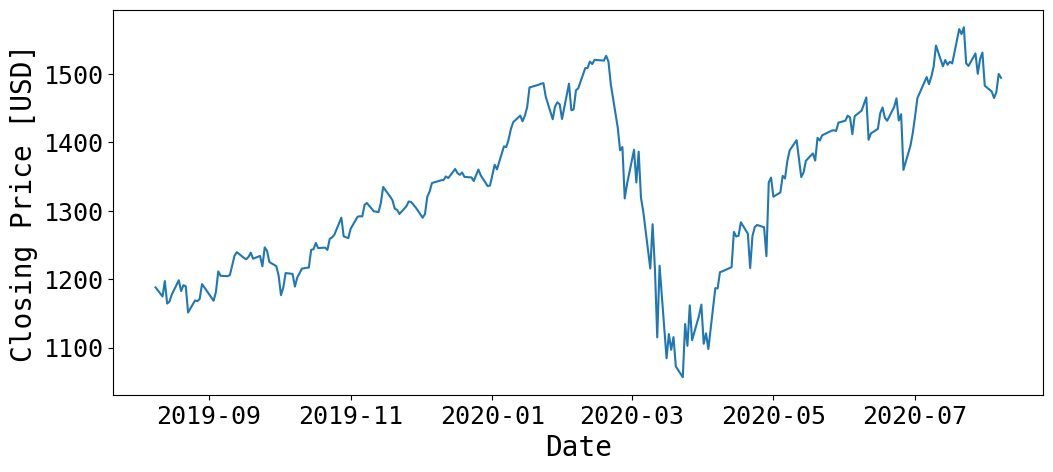

In [282]:
plt.plot(pd.to_datetime(raw_df['Date']), raw_df['Close'])
plt.ylabel('Closing Price [USD]')
plt.xlabel('Date')
plt.show()

Remove all but Date and Close, and construct new columns "Close 1 day before", ..., "Close 7 days before", and split into y (Close), and X (Close 1 to 7 days before).

In [292]:
data = raw_df[['Date', 'Close']]
sequence_length = 10

def prep_data(df, sequence_length):
    df = df.copy()  # Make a copy of the DataFrame
    df.set_index('Date', inplace=True)

    for i in range(1, sequence_length + 1):
        column_name = f'Close (t-{i})'
        
        df.loc[:, column_name] = df['Close'].shift(i)
   
    df.dropna(inplace=True)

    return df

new_data = prep_data(data, sequence_length)
new_data

,Close,Close (t-1),Close (t-2),Close (t-3),Close (t-4),Close (t-5),Close (t-6),Close (t-7),Close (t-8),Close (t-9),Close (t-10)
Date,,,,,,,,,,,
2019-08-23,1151.290039,1189.530029,1191.250000,1182.689941,1198.449951,1177.599976,1167.260010,1164.290039,1197.270020,1174.709961,1188.010010
2019-08-26,1168.890015,1151.290039,1189.530029,1191.250000,1182.689941,1198.449951,1177.599976,1167.260010,1164.290039,1197.270020,1174.709961
2019-08-27,1167.839966,1168.890015,1151.290039,1189.530029,1191.250000,1182.689941,1198.449951,1177.599976,1167.260010,1164.290039,1197.270020
2019-08-28,1171.020020,1167.839966,1168.890015,1151.290039,1189.530029,1191.250000,1182.689941,1198.449951,1177.599976,1167.260010,1164.290039
2019-08-29,1192.849976,1171.020020,1167.839966,1168.890015,1151.290039,1189.530029,1191.250000,1182.689941,1198.449951,1177.599976,1167.260010
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-03,1474.449951,1482.959961,1531.449951,1522.020020,1500.339966,1530.199951,1511.869995,1515.680054,1568.489990,1558.420044,1565.719971
2020-08-04,1464.969971,1474.449951,1482.959961,1531.449951,1522.020020,1500.339966,1530.199951,1511.869995,1515.680054,1568.489990,1558.420044
2020-08-05,1473.609985,1464.969971,1474.449951,1482.959961,1531.449951,1522.020020,1500.339966,1530.199951,1511.869995,1515.680054,1568.489990


In [293]:
np_df = new_data.to_numpy()

In [294]:

print(np_df[0])
# Scale the data to the range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
np_df_scaled = scaler.fit_transform(np_df)
np_df_unscaled = scaler.inverse_transform(np_df_scaled)
print(np_df_scaled[0])
print(np_df_unscaled[0])

# The first column (y) is what we are trying to predict using the other columns (X), so:
X = np_df_scaled[:,1:]
X = np.flip(X, axis=1) # Such that the column with the highest index is the newest
y = np_df_scaled[:,0]



[1151.290039 1189.530029 1191.25     1182.689941 1198.449951 1177.599976
 1167.26001  1164.290039 1197.27002  1174.709961 1188.01001 ]
[-0.63010122 -0.48068832 -0.47396798 -0.5074142  -0.44583602 -0.52730192
 -0.56770267 -0.57930707 -0.4504463  -0.53859391 -0.4866274 ]
[1151.290039 1189.530029 1191.25     1182.689941 1198.449951 1177.599976
 1167.26001  1164.290039 1197.27002  1174.709961 1188.01001 ]


Torch LSTM requires input data have an extra dimension, so (232,7) --> (232,7,1).

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train = X_train[:, :, np.newaxis]
X_test  = X_test[:, :,  np.newaxis]
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
 

(205, 10) (37, 10) (205,) (37,)
(205, 10, 1) (37, 10, 1) (205, 1) (37, 1)


Now convert data to the Torch datastructure torch.tensors.

In [296]:
import torch
torch.set_default_dtype(torch.float32)
# Assuming X_train, X_test, y_train, y_test are your NumPy arrays
X_train= torch.from_numpy(X_train).float()
X_test= torch.from_numpy(X_test).float()
y_train= torch.from_numpy(y_train).float()
y_test= torch.from_numpy(y_test).float()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([205, 10, 1]) torch.Size([37, 10, 1]) torch.Size([205, 1]) torch.Size([37, 1])


In [297]:
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_dataset = StockDataset(X_train, y_train)
test_dataset  = StockDataset(X_test, y_test)

In [298]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader  = DataLoader(test_dataset,  batch_size = batch_size, shuffle = False)

for _, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0], batch[1]
    print(x_batch.shape)
    print(y_batch.shape)

torch.Size([16, 10, 1])
torch.Size([16, 1])
torch.Size([16, 10, 1])
torch.Size([16, 1])
torch.Size([5, 10, 1])
torch.Size([5, 1])


In [299]:

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([205, 10, 1]) torch.Size([37, 10, 1]) torch.Size([205, 1]) torch.Size([37, 1])


In [300]:
# Inverse transform to recover the original prices in USD

def inverse_transform(df):
    df = df.flatten()
    dummies = np.zeros((df.shape[0], sequence_length+1))
    dummies[:, 0] = df
    dummies = scaler.inverse_transform(dummies)

    return dummies[:, 0]

train_predictions_unscaled = inverse_transform(train_predictions)
test_predictions_unscaled  = inverse_transform(test_predictions)
y_train_unscaled           = inverse_transform(y_train)
y_test_unscaled            = inverse_transform(y_test)

def plot_loss():
    fig, ax = plt.subplots(2,1, figsize=(12,8))

    ax[0].plot(train_loss, label='Training loss')
    ax[0].plot(val_loss, label='Validation loss')
    ax[0].legend()
    max_y = np.max(train_loss)+0.1
    ax[0].set(xlabel='Epochs', ylabel='Loss', ylim=(0,max_y))

    ax[1].plot(train_loss, label='Training loss')
    ax[1].plot(val_loss, label='Validation loss')
    ax[1].legend()
    max_y = np.max(val_loss)+0.1
    ax[1].set(xlabel='Epochs', ylabel='Loss', ylim=(0, max_y))
    plt.tight_layout()
    

def plot_predictions():
    # Plotting
    fig, ax = plt.subplots(2,1, figsize=(12,8))
    ax[0].plot(y_test_unscaled, label='True')
    ax[0].plot(test_predictions_unscaled, label='Predicted')
    ax[0].legend()
    ax[0].set(title = 'Test set', xlabel='Days', ylabel='Price at Close [USD]')
        
    ax[1].plot(y_train_unscaled, label='True')
    ax[1].plot(train_predictions_unscaled, label='Predicted')
    ax[1].legend()
    ax[1].set(title='Train set', xlabel='Days', ylabel='Price at Close [USD]')    
    plt.tight_layout()

def train_one_epoch():
    model.train()
    print(f'Epoch {epoch + 1}')
    total_train_loss = 0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        current_loss = loss.item()
        total_train_loss += current_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 5 == 0:
            print(f'Batch {batch_index} | Loss: {current_loss:.3f}')
    
    avg_train_loss = total_train_loss / len(train_loader)
    print(f'Average train loss: {avg_train_loss:.4f}')
    return total_train_loss

def validate_one_epoch():
    model.train(False)
    total_val_loss = 0

    with torch.no_grad():
        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0], batch[1]

            output = model(x_batch)
            loss = loss_function(output, y_batch)
            current_loss = loss.item()
            total_val_loss += current_loss
            #if batch_index % 5 == 0:
            #    print(f'Batch {batch_index} | Loss: {current_loss:.3f}')

    avg_val_loss = total_val_loss / len(test_loader)
    print(f'Average validation loss: {avg_val_loss:.4f}\n')
    return total_val_loss



In [303]:
# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        # LTSM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        #Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

model = LSTM(input_size = 1, hidden_size = 5, num_stacked_layers = 1)


learning_rate = 0.001
n_epochs = 60
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []
val_loss = []

for epoch in range(n_epochs):
    train_loss.append(train_one_epoch())
    val_loss.append(validate_one_epoch())

Epoch 1
Batch 0 | Loss: 0.386
Batch 5 | Loss: 0.081
Batch 10 | Loss: 0.230
Average train loss: 0.2380
Average validation loss: 0.2222

Epoch 2
Batch 0 | Loss: 0.304
Batch 5 | Loss: 0.127
Batch 10 | Loss: 0.127
Average train loss: 0.2147
Average validation loss: 0.2522

Epoch 3
Batch 0 | Loss: 0.153
Batch 5 | Loss: 0.180
Batch 10 | Loss: 0.247
Average train loss: 0.1955
Average validation loss: 0.2849

Epoch 4
Batch 0 | Loss: 0.097
Batch 5 | Loss: 0.124
Batch 10 | Loss: 0.189
Average train loss: 0.1790
Average validation loss: 0.3083

Epoch 5
Batch 0 | Loss: 0.196
Batch 5 | Loss: 0.273
Batch 10 | Loss: 0.149
Average train loss: 0.1658
Average validation loss: 0.3275

Epoch 6
Batch 0 | Loss: 0.119
Batch 5 | Loss: 0.162
Batch 10 | Loss: 0.169
Average train loss: 0.1549
Average validation loss: 0.3410

Epoch 7
Batch 0 | Loss: 0.219
Batch 5 | Loss: 0.210
Batch 10 | Loss: 0.119
Average train loss: 0.1443
Average validation loss: 0.3452

Epoch 8
Batch 0 | Loss: 0.172
Batch 5 | Loss: 0.113
Bat

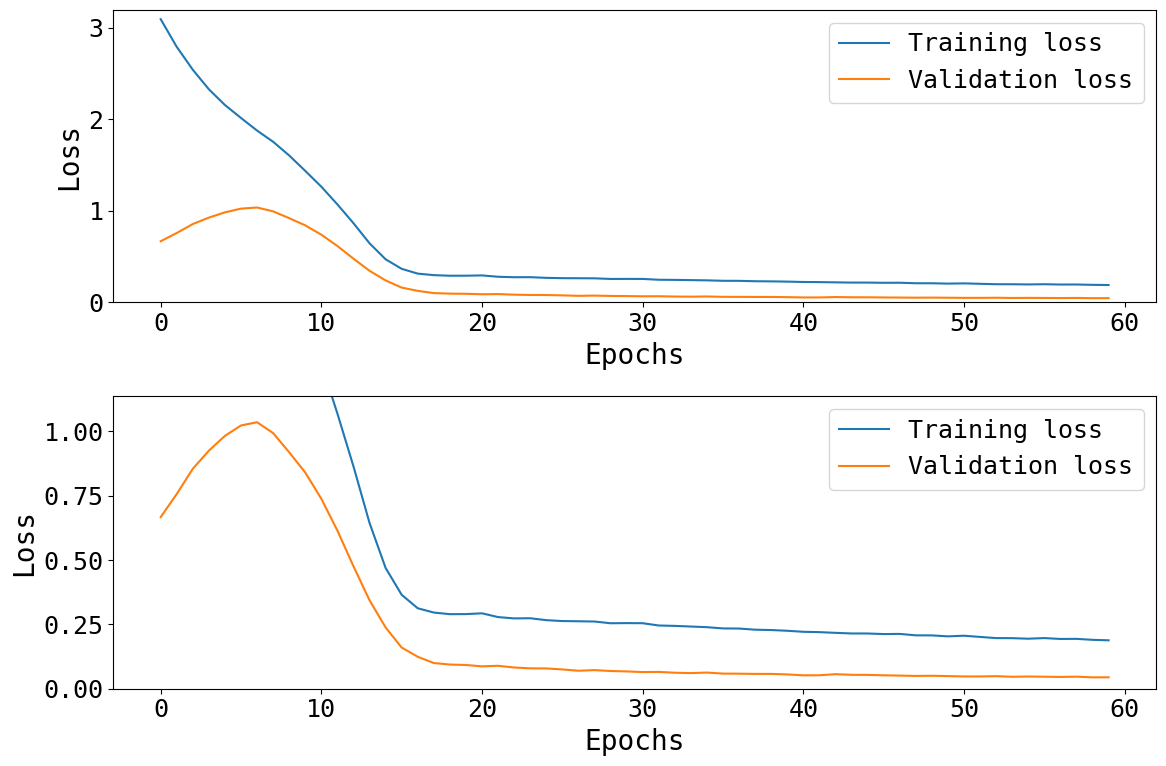

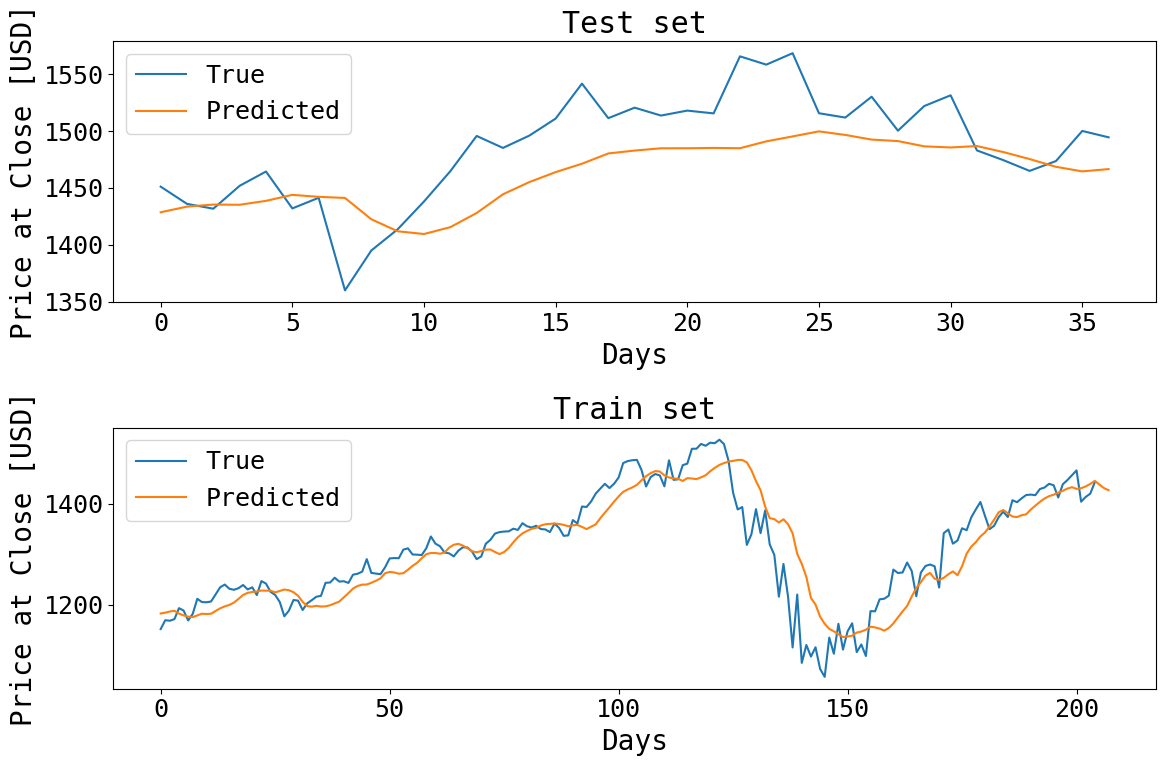

In [304]:
with torch.no_grad():
    test_predictions = model(X_test).numpy()
    train_predictions = model(X_train).numpy()

plot_loss()
plot_predictions()
